In [50]:
import numpy as np
import scipy.linalg as la
import itertools as it
import time
import pylab as pl
import random
from mpl_toolkits.mplot3d import Axes3D

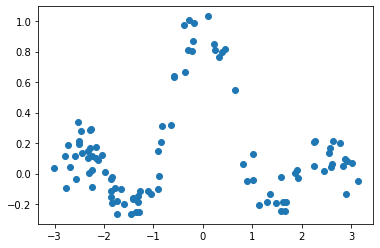

In [6]:
# Test
def noisysincfunction(N, noise):
    ''' noisysincfunction - generate data from the "noisy sinc function"
        % usage
        %     [X, Y] = noisysincfunction(N, noise)
        %
        % input
        %     N: number of data points
        %     noise: standard variation of the noise
        %
        % output
        %     X: (1, N)-matrix uniformly sampled in -2pi, pi
        %     Y: (1, N)-matrix equal to sinc(X) + noise
        %
        % description
        %     Generates N points from the noisy sinc function
        %
        %        X ~ uniformly in [-2pi, pi]
        %        Y = sinc(X) + eps, eps ~ Normal(0, noise.^2)
        %
        % author
        %     Mikio Braun
    '''
    X = np.sort(2 * np.pi * np.random.rand(1, N) ) - np.pi
    Y = np.sinc(X) + noise * np.random.randn(1, N)
    return X.reshape(-1, 1), Y.flatten()
Xtr, Ytr = noisysincfunction(100, 0.1)
Xte = np.arange( -np.pi, np.pi, 0.01 ).reshape(-1, 1)
pl.plot(Xtr,Ytr, 'o')

In [267]:
X = Xtr
y = Ytr

In [ ]:
def zero_one_loss(y_true, y_pred):
    ''' your header here!
    '''
    

In [265]:
def mean_absolute_error(y_true, y_pred):
    ''' 
    your code here 
    '''
    loss = np.sum(((y_pred-y_true)**2)**0.5) / len(y_pred)
    return loss

In [ ]:
def cv(X, y, method, params, loss_function=mean_absolute_error, nfolds=10, nrepetitions=5):
    ''' 
    your header here!
    '''
    length, width = np.shape(Xtr)
    for parameter in it.product(parameters['key1'],parameters['key2'])
        for i in range(nrepetitions):
            e_avg = 0
            # Random Partitioning
            X_pos = np.linspace(0,length-1, length)
            random.shuffle(X_pos)
            part = np.array_split(X_pos, nfolds)
            for j in range(nfolds):
                # Assign every part not j as training set
                # Xtr indices
                train = np.concatenate(np.array(part)[tuple([np.array(range(nfolds)) != j])]) 
                X_j = X[train]
                y_j = y[train]
                method.fit(X_j, y_j)
                y_pred = method.predict(X[part[j]])
                e = e + loss_function(y[part[j], y_pred])
        e = e / nfolds * nrepetitions
    return method

In [273]:
class krr():
    ''' your header here!
    '''
    def __init__(self, kernel='linear', kernelparameter=1, regularization=0):
        self.kernel = kernel
        self.kernelparameter = kernelparameter
        self.regularization = regularization

    def fit(self, X, y, kernel=False, kernelparameter=False, regularization=False):
        ''' your header here!
        '''
        if kernel is not False:
            self.kernel = kernel
        if kernelparameter is not False:
            self.kernelparameter = kernelparameter
        if regularization is not False:
            self.regularization = regularization
        if self.kernel == 'linear':
            self.kernelmatrix = X.T.dot(X)
        elif self.kernel == 'polynomial':
            self.kernelmatrix = (X.T.dot(X)+1)**self.kernelparameter
        #elif self.kernel == 'gaussian':
        #    self.kernelmatrix = np.exp(-np.linalg.norm(X[None, :] - X[:,None], axis = 2)**2/(2*self.kernelparameter)**2)

        return self

    def predict(self, X):
        ''' your header here!
        '''
        return self


In [290]:
# linear kernel
X.T.dot(X)

array([[357.42454284]])

In [279]:
test = method.fit(Xtr,Ytr)

In [184]:
e_avg = 0
length, width = np.shape(Xtr)
k = 5
# Random Partitioning
array = np.array(range(0,length))
random.Random(seed).shuffle(array)
part = np.array_split(array, k)
for j in range(k):
    # Assign every part not j as training set
    # Xtr indices
    train = np.concatenate(np.array(part)[tuple([np.array(range(k)) != j])]) 
    X_j = X[train]
    y_j = y[train]
    method.fit(X_j, y_j)
    y_pred = method.predict(X[part[j]])
    e = e + loss_function(y[part[j], y_pred])

In [269]:
np.array(part)

array([[73, 86, 82, 23,  1, 42, 57, 40, 76, 69, 25, 94,  9, 41, 88, 83,
        74, 91, 67, 95],
       [79, 75,  6, 72,  4, 71, 63, 62, 20, 65, 89, 60, 29, 56, 59, 90,
        16, 84, 14, 10],
       [85, 44, 58, 98, 77, 26, 12, 32, 48, 54, 45, 36, 18,  0, 93, 53,
        81, 55, 52,  5],
       [17, 99, 15, 80, 31, 64, 49, 43, 96, 47, 87, 39, 21, 24, 34, 78,
         3, 27, 33, 97],
       [22, 35, 46, 68, 66, 28,  7, 37, 70, 51,  2,  8, 11, 19, 61, 50,
        92, 13, 38, 30]])

In [262]:
train = np.concatenate(np.array(part)[tuple([np.array(range(k)) != j])])

In [271]:
Xtr[part[j]]

array([[-2.1667773 ],
       [-1.60085082],
       [-0.90474632],
       [ 0.80515206],
       [ 0.43998515],
       [-1.85977173],
       [-2.52885584],
       [-1.41944831],
       [ 1.02201808],
       [-0.63847983],
       [-2.7641784 ],
       [-2.51567777],
       [-2.44158305],
       [-2.24314595],
       [ 0.09750934],
       [-0.82943265],
       [ 2.63488265],
       [-2.32327049],
       [-1.41760621],
       [-1.82927739]])

In [258]:
for j in range(k):
    print(np.array(part)[tuple([np.array(range(k)) != j])])

[[79 75  6 72  4 71 63 62 20 65 89 60 29 56 59 90 16 84 14 10]
 [85 44 58 98 77 26 12 32 48 54 45 36 18  0 93 53 81 55 52  5]
 [17 99 15 80 31 64 49 43 96 47 87 39 21 24 34 78  3 27 33 97]
 [22 35 46 68 66 28  7 37 70 51  2  8 11 19 61 50 92 13 38 30]]
[[73 86 82 23  1 42 57 40 76 69 25 94  9 41 88 83 74 91 67 95]
 [85 44 58 98 77 26 12 32 48 54 45 36 18  0 93 53 81 55 52  5]
 [17 99 15 80 31 64 49 43 96 47 87 39 21 24 34 78  3 27 33 97]
 [22 35 46 68 66 28  7 37 70 51  2  8 11 19 61 50 92 13 38 30]]
[[73 86 82 23  1 42 57 40 76 69 25 94  9 41 88 83 74 91 67 95]
 [79 75  6 72  4 71 63 62 20 65 89 60 29 56 59 90 16 84 14 10]
 [17 99 15 80 31 64 49 43 96 47 87 39 21 24 34 78  3 27 33 97]
 [22 35 46 68 66 28  7 37 70 51  2  8 11 19 61 50 92 13 38 30]]
[[73 86 82 23  1 42 57 40 76 69 25 94  9 41 88 83 74 91 67 95]
 [79 75  6 72  4 71 63 62 20 65 89 60 29 56 59 90 16 84 14 10]
 [85 44 58 98 77 26 12 32 48 54 45 36 18  0 93 53 81 55 52  5]
 [22 35 46 68 66 28  7 37 70 51  2  8 11 19 61 50 92

In [243]:
np.array([1,30,40,5,0])[tuple([np.array(range(k)) != j])]

array([30, 40,  5,  0])

In [236]:
part[[tuple([np.array(range(k)) != j])]]

TypeError: list indices must be integers or slices, not list

In [235]:
np.array(range(k))[tuple([np.array(range(k)) != j])]

array([1, 2, 3, 4])

In [213]:
part[np.array(range(k))[True, True, True, False, False]]

TypeError: only integer scalar arrays can be converted to a scalar index

In [223]:
np.array(range(k))[[np.array(range(k)) != j]]

/Users/leo/anaconda3/envs/Python37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


array([1, 2, 3, 4])

In [105]:
Xtr[np.concatenate(part[[0:0, 0:]])]

SyntaxError: invalid syntax (<ipython-input-105-c9b5012e0ffc>, line 1)

In [120]:
np.concatenate(part[0:1])

array([73, 86, 82, 23,  1, 42, 57, 40, 76, 69, 25, 94,  9, 41, 88, 83, 74,
       91, 67, 95])

In [121]:
len(part)

5

In [118]:
range(3)

range(0, 3)

In [53]:
array = np.linspace(0,length-1, length)
random.Random(4).shuffle(array)
np.array_split(array, 5)

[array([73., 86., 82., 23.,  1., 42., 57., 40., 76., 69., 25., 94.,  9.,
        41., 88., 83., 74., 91., 67., 95.]),
 array([79., 75.,  6., 72.,  4., 71., 63., 62., 20., 65., 89., 60., 29.,
        56., 59., 90., 16., 84., 14., 10.]),
 array([85., 44., 58., 98., 77., 26., 12., 32., 48., 54., 45., 36., 18.,
         0., 93., 53., 81., 55., 52.,  5.]),
 array([17., 99., 15., 80., 31., 64., 49., 43., 96., 47., 87., 39., 21.,
        24., 34., 78.,  3., 27., 33., 97.]),
 array([22., 35., 46., 68., 66., 28.,  7., 37., 70., 51.,  2.,  8., 11.,
        19., 61., 50., 92., 13., 38., 30.])]

In [38]:
array = np.linspace(0,length-1, length)

In [39]:
array

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96., 97., 98., 99.])